# Canadian Rental Prices Regression Model

## Introduction

This notebook works with data that was preprocessed in [this notebook](DataPreprocessing.ipynb). Multiple regression models will be explored and the model that predicts the price of Canada rentals the most accurately will be chosen.

In [4]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNet, ElasticNetCV, LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import warnings

In [5]:
# Load data
df = pd.read_csv('Data/preprocessed_data.csv')
df.shape

(18832, 11)

### Create helper functions

In [7]:
def get_summary(model, X_test, y_test):
    summary = model.summary2()
    y_pred = model.predict(X_test)

    R2 = summary.tables[0].iloc[6,1]
    durbin_watson = summary.tables[2].iloc[0,3]
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    test_mean = y_test.mean()
    pred_mean = y_pred.mean()
    ratio = RMSE / test_mean

    metrics = {
        'R-squared': float(R2),
        'Durbin-Watson': float(durbin_watson),
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        'Test Mean': test_mean,
        'Predictions Mean': pred_mean,
        'RMSE to test mean ratio': ratio
    }

    df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])
    df['Value'] = df['Value'].apply(lambda x: '%.4f' % x)

    return df

In [8]:
def get_summary2(model, X_test, y_test):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    R2 = r2_score(y_test, y_pred)
    dw = durbin_watson(residuals)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    test_mean = y_test.mean()
    pred_mean = y_pred.mean()
    ratio = RMSE / test_mean

    metrics = {
        'R-squared': R2,
        'Durbin-Watson': dw,
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        'Test Mean': test_mean,
        'Predictions Mean': pred_mean,
        'RMSE to test mean ratio': ratio
    }

    df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])
    df['Value'] = df['Value'].apply(lambda x: '%.4f' % x)

    return df

In [9]:
def get_coefficients(model):
    df = model.summary2().tables[1]
    df['Coef.'] = df['Coef.'].astype('float').apply(lambda x: '%.4f' % x)
    df['P>|t|'] = df['P>|t|'].astype('float').apply(lambda x: '%.4f' % x)
    return df[['Coef.', 'P>|t|']]

In [10]:
def plot_residuals(y_test, y_pred):
    '''Plots the residuals and the Q-Q Plot in the same figure'''
    residuals = y_test - y_pred
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(15, 6))
    
    sns.scatterplot(x=y_pred, y=residuals, ax=ax1)
    ax1.set_title("Residual Plot")
    ax1.set_xlabel("Prediction")
    ax1.set_ylabel("Residuals")
    ax1.axhline(0, linestyle="--", color="orange")

    ax2.hist(residuals, bins=50)
    ax2.set_title("Distribution of the residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title("Normal Q-Q Plot")  

    plt.tight_layout()
    plt.show()

---

## 1. First Model: Linear Regression

### 1.1 Base model

In [14]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=54)

In [16]:
# Train model
X_train_constant = sm.add_constant(X_train)
X_test_constant = sm.add_constant(X_test)
base_model = sm.OLS(y_train, X_train_constant).fit()

In [17]:
# Evaluate model
get_summary(base_model, X_test_constant, y_test)

,Metric,Value
0,R-squared,0.2990
1,Durbin-Watson,1.9780
2,MAE,498.2674
3,MSE,522567.3973
4,RMSE,722.8882
5,Test Mean,2168.5361
6,Predictions Mean,2161.7765
7,RMSE to test mean ratio,0.3334


In [18]:
# Get intercept and coefficients
get_coefficients(base_model)

,Coef.,P>|t|
const,396.6014,0.0000
beds,184.7659,0.0000
baths,492.4580,0.0000
sq_feet,0.2374,0.0000
cats,-52.1031,0.0332
dogs,218.8542,0.0000
postal_code,0.4498,0.0000
furnished,264.6490,0.0000
type_Apartment,516.8703,0.0000
type_Basement,-21.9751,0.4715


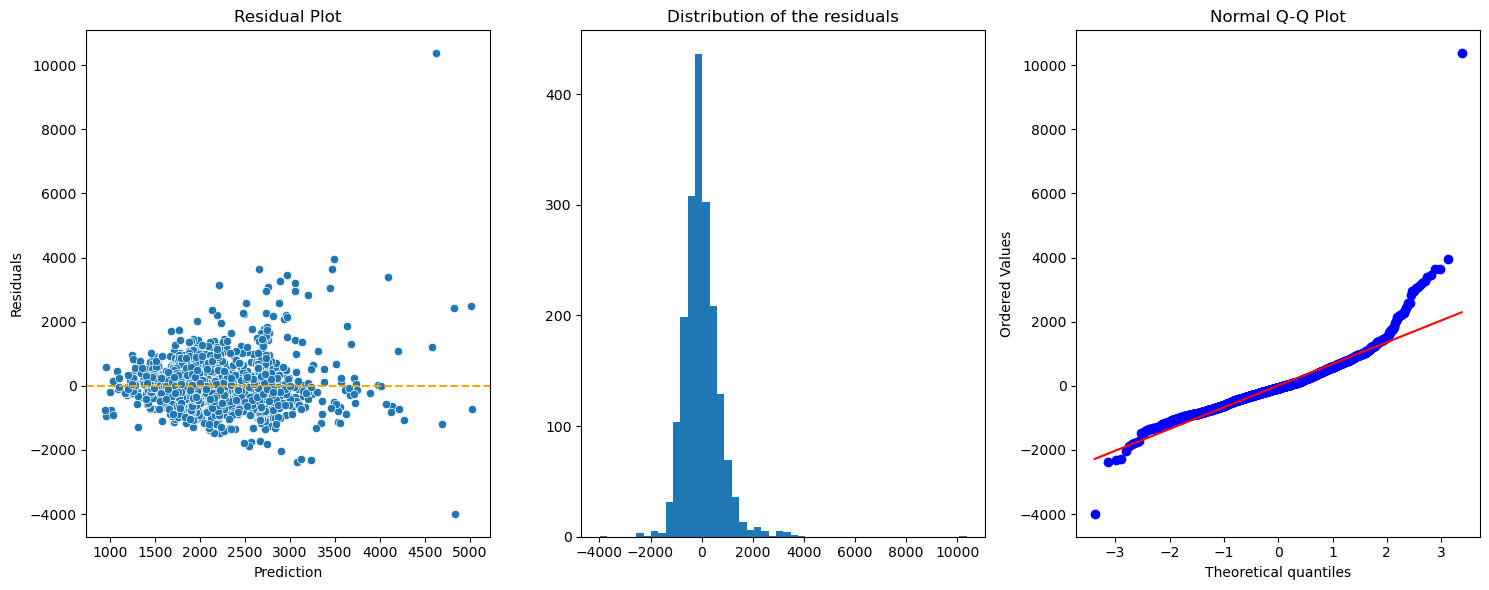

In [19]:
# Plot residuals
y_pred = base_model.predict(X_test_constant)
plot_residuals(y_test, y_pred)

**Observations**

The R-squared is 0.299, which indicates that 29.9% of the variance of the price is explained by the model, which suggests a poor fit.
Compared to the mean values, the MAE and RMSE are pretty high, which indicates our model doesn't perform really well.

The Durbin-Watson score of 1.978 indicates that the errors and independent. However, based on the residual plots, there are big outliers with a residual of over 4000. Other than that, the residuals are pretty symmetrical.

All the features are statistically significant based on the p-values, except the basement.

### 1.2 Model refinement

In [22]:
# Drop outliers
y_pred = base_model.predict(X_test_constant)
residuals = y_test - y_pred
pos_outliers = set(residuals[residuals > 4000].index)

while len(pos_outliers) > 0:
    df = df.drop(pos_outliers).reset_index(drop=True)
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=54)
    
    X_train_constant = sm.add_constant(X_train)
    X_test_constant = sm.add_constant(X_test)
    base_model = sm.OLS(y_train, X_train_constant).fit()
    
    y_pred = base_model.predict(X_test_constant)
    residuals = y_test - y_pred
    pos_outliers = set(residuals[residuals > 4000].index)

In [23]:
# Evaluate model
get_summary(base_model, X_test_constant, y_test)

,Metric,Value
0,R-squared,0.3310
1,Durbin-Watson,1.9810
2,MAE,488.5089
3,MSE,444143.1885
4,RMSE,666.4407
5,Test Mean,2131.3553
6,Predictions Mean,2140.6921
7,RMSE to test mean ratio,0.3127


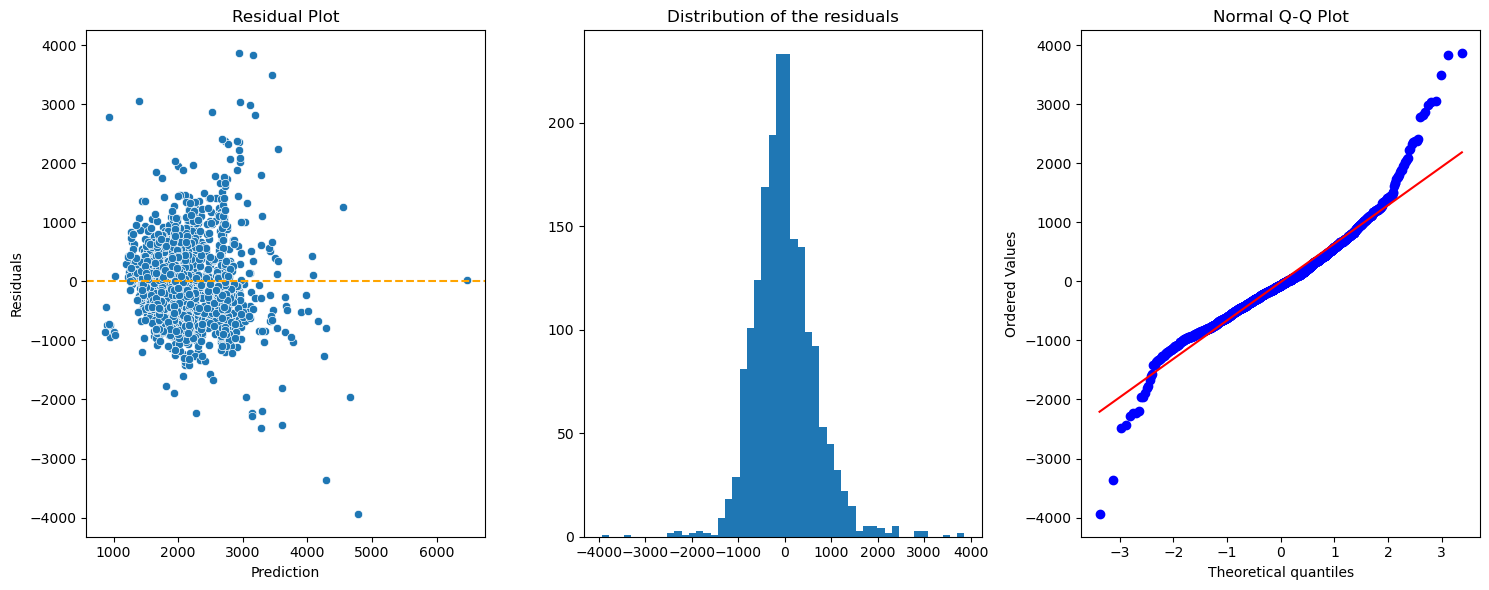

In [24]:
# Plot residuals
y_pred = base_model.predict(X_test_constant)
plot_residuals(y_test, y_pred)

**Observations**

Removing the outliers improved the R-squared a little bit (0.299 to 0.3310) and the RMSE went from 722.8882 to 666.4407, which is a slight improvement. The tails of the Q-Q Plot indicates there might be a non-linear relationship between variables.

In [26]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Train model
X_train_scaled_constant = sm.add_constant(X_train_scaled)
const = np.ones(len(X_test_scaled))
X_test_scaled_constant = np.insert(X_test_scaled, 0, const, axis=1) # sm.add_constant(X_test_scaled) doesn't work
scaled_model = sm.OLS(y_train, X_train_scaled_constant).fit()

In [28]:
# Evaluate model
get_summary(scaled_model, X_test_scaled_constant, y_test)

,Metric,Value
0,R-squared,0.3310
1,Durbin-Watson,1.9810
2,MAE,488.5089
3,MSE,444143.1885
4,RMSE,666.4407
5,Test Mean,2131.3553
6,Predictions Mean,2140.6921
7,RMSE to test mean ratio,0.3127


**Observations**

Scaling the data doesn't make a difference.

---

## 2. Polynomial regression

### 2.1 Base model

In [33]:
# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

In [34]:
# Add polynomial features
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(X)
X_poly = pd.DataFrame(poly_features, columns=poly_converter.get_feature_names_out())

X.shape, poly_features.shape

((18819, 10), (18819, 65))

In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.10, random_state=54)

In [36]:
# Train model
X_train_constant = sm.add_constant(X_train)
X_test_constant = sm.add_constant(X_test)
poly_model = sm.OLS(y_train, X_train_constant).fit()

In [37]:
# Evaluate model
get_summary(poly_model, X_test_constant, y_test)

,Metric,Value
0,R-squared,0.4220
1,Durbin-Watson,1.9850
2,MAE,471.0830
3,MSE,397648.6920
4,RMSE,630.5939
5,Test Mean,2131.3553
6,Predictions Mean,2133.8800
7,RMSE to test mean ratio,0.2959


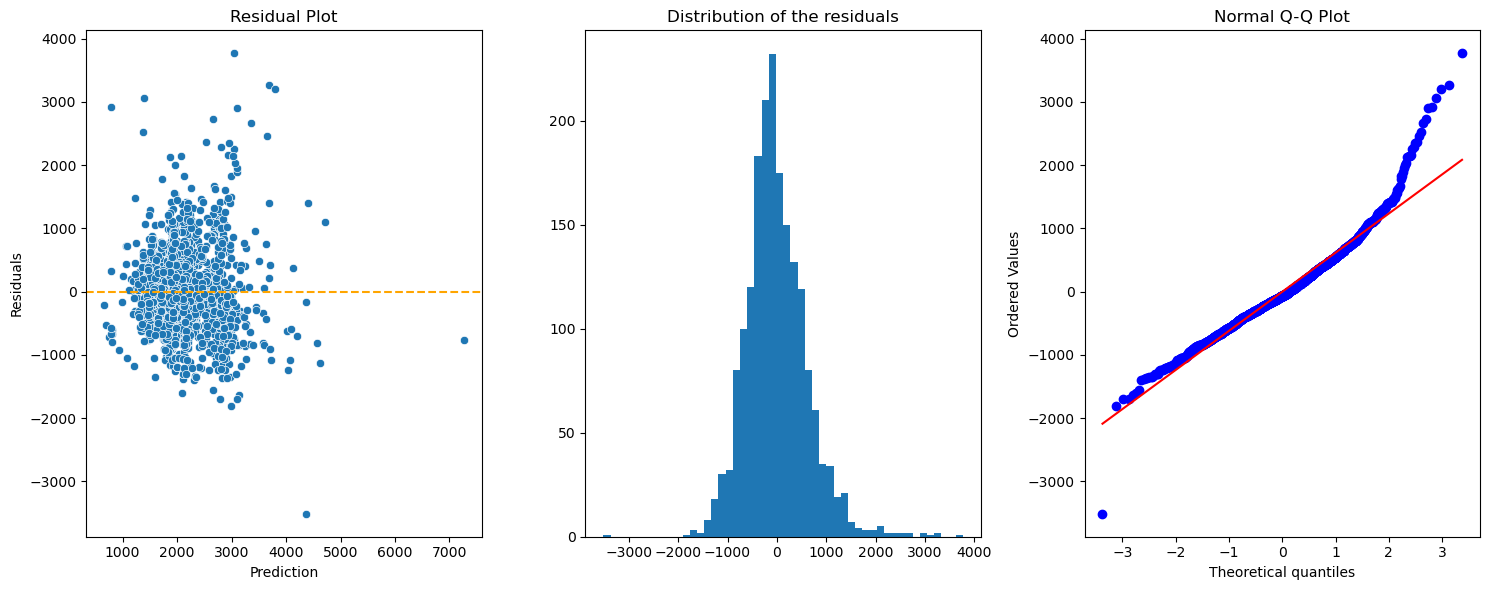

In [38]:
# Plot residuals
y_pred = poly_model.predict(X_test_constant)
plot_residuals(y_test, y_pred)

**Observations**

The R-squared went from 0.3310 to 0.4220 and the RMSE went from 666.4407 to 630.5939, which is an improvement from the linear regression model. However, there are still outliers.

### 2.2 Model refinement

In [41]:
# Get coefficients
get_coefficients(poly_model)

,Coef.,P>|t|
const,1604.1087,0.0000
beds,430.7307,0.0000
baths,167.1858,0.0019
sq_feet,-0.8135,0.0000
cats,-343.4368,0.0000
...,...,...
type_Apartment type_Basement,0.0000,nan
type_Apartment type_House,0.0000,nan
type_Basement^2,-142.9363,0.0568
type_Basement type_House,0.0000,nan


In [42]:
# Only keep statistically significant variables (95% confidence interval)
selected_features = list(poly_model.pvalues[poly_model.pvalues <= 0.05].index)[1:] # remove intercept

while len(selected_features) < len(X_poly.columns):
    X_poly = X_poly[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.10, random_state=54)
    X_train_constant = sm.add_constant(X_train)
    X_test_constant = sm.add_constant(X_test)
    poly_model = sm.OLS(y_train, X_train_constant).fit()
    selected_features = list(poly_model.pvalues[poly_model.pvalues <= 0.05].index)[1:]

In [43]:
# Evaluate model
get_summary(poly_model, X_test_constant, y_test)

,Metric,Value
0,R-squared,0.4200
1,Durbin-Watson,1.9830
2,MAE,471.8149
3,MSE,398732.4592
4,RMSE,631.4527
5,Test Mean,2131.3553
6,Predictions Mean,2133.0933
7,RMSE to test mean ratio,0.2963


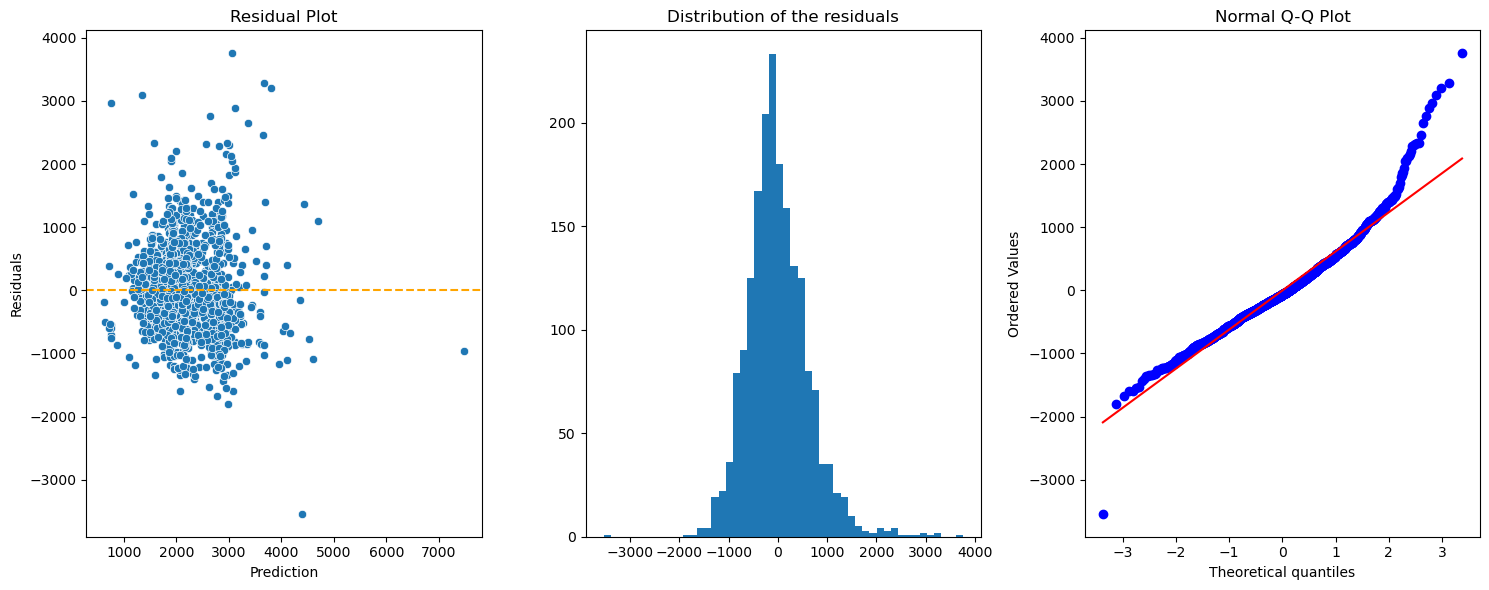

In [44]:
# Plot residuals
y_pred = poly_model.predict(X_test_constant)
plot_residuals(y_test, y_pred)

**Observations**

The performance decresed a little bit but our model is simpler to interpret.

In [46]:
# Drop outliers
y_pred = poly_model.predict(X_test_constant)
residuals = y_test - y_pred
pos_outliers = set(residuals[np.abs(residuals) > 1750].index)

while len(pos_outliers) > 0:
    df = df.drop(pos_outliers).reset_index(drop=True)
    X = df.drop('price', axis=1)
    y = df['price']

    poly_converter = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly_converter.fit_transform(X)
    X_poly = pd.DataFrame(poly_features, columns=poly_converter.get_feature_names_out())
    
    X_poly = X_poly[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.10, random_state=54)

    X_train_constant = sm.add_constant(X_train)
    X_test_constant = sm.add_constant(X_test)
    poly_model = sm.OLS(y_train, X_train_constant).fit()
    
    y_pred = poly_model.predict(X_test_constant)
    residuals = y_test - y_pred
    pos_outliers = set(residuals[np.abs(residuals) > 1750].index)

In [47]:
# Evaluate model
get_summary(poly_model, X_test_constant, y_test)

,Metric,Value
0,R-squared,0.4140
1,Durbin-Watson,2.0090
2,MAE,434.1259
3,MSE,301913.5836
4,RMSE,549.4666
5,Test Mean,2100.6365
6,Predictions Mean,2100.3226
7,RMSE to test mean ratio,0.2616


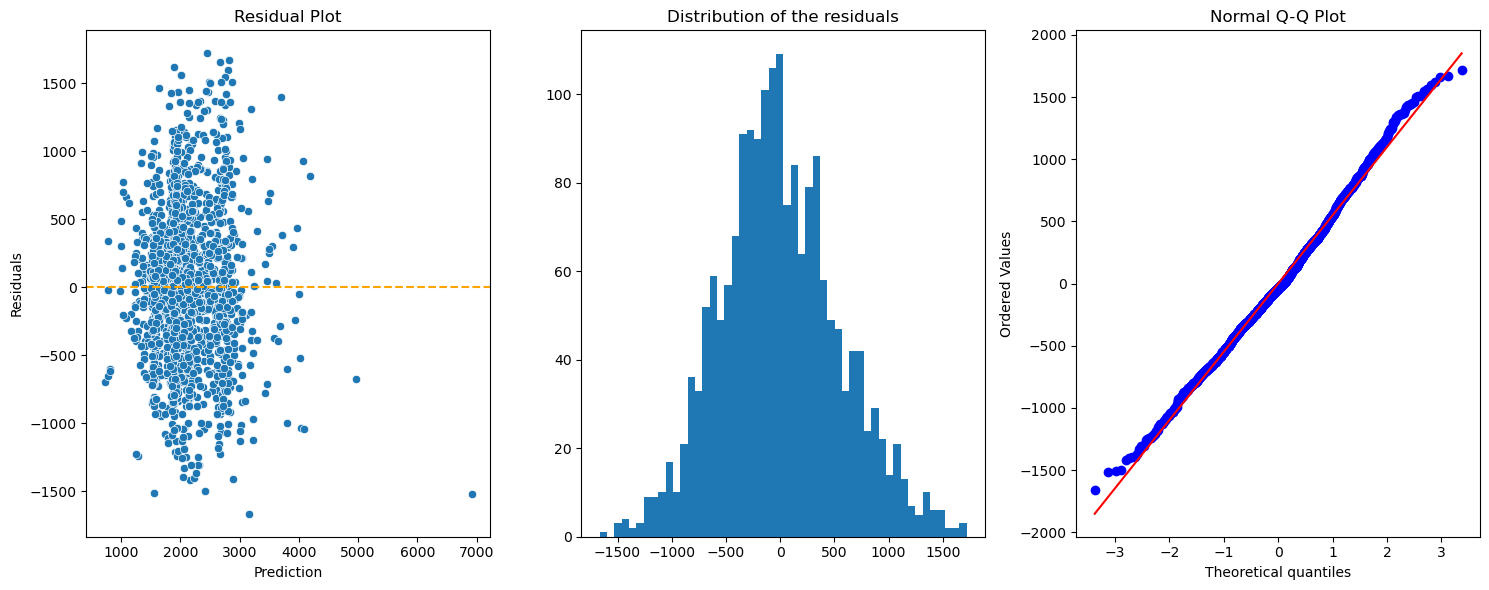

In [48]:
# Plot residuals
y_pred = poly_model.predict(X_test_constant)
plot_residuals(y_test, y_pred)

The R-squared decreased but the RMSE went from 631.4527 to 549.4666, which is an improvement. After removing the outliers, the residuals are almost normally distributed. This is the best model so far.

---

## 3. Regularization, cross-validation and grid search

In [52]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### 3.2 ElasticNet Grid Search

In [54]:
# Suppress only ConvergenceWarnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

In [55]:
# Fit model
elastic_net_model = ElasticNet()

param_grid = {'alpha': [0.1, 1, 5, 10, 50, 100],
              'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}

grid_model = GridSearchCV(estimator=elastic_net_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1)

grid_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [56]:
# Optimal alpha and l1_ratio values
grid_model.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.99)

In [57]:
# Evaluate model
get_summary2(grid_model, X_test_scaled, y_test)

,Metric,Value
0,R-squared,0.4376
1,Durbin-Watson,2.0124
2,MAE,433.9841
3,MSE,301716.4336
4,RMSE,549.2872
5,Test Mean,2100.6365
6,Predictions Mean,2100.3792
7,RMSE to test mean ratio,0.2615


The R-squared went from 0.4140 to 0.4376 and the RMSE went from 549.4666 to 549.2872. The ElasticNet Grid Search didn't really improve the performance.

### 3.3 ElasticNet Cross Validation

In [60]:
# ElasticCV model
cv_model = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], eps=0.01, n_alphas=200, max_iter=10000)
cv_model.fit(X_train_scaled, y_train)

ElasticNetCV(eps=0.01, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             max_iter=10000, n_alphas=200)

In [61]:
# L1 ratio comparison
print(f'ElasticNet Grid Search L1 ratio: {grid_model.best_estimator_.l1_ratio}\nElasticNet CV L1 ratio: {cv_model.l1_ratio_}')

ElasticNet Grid Search L1 ratio: 0.99
ElasticNet CV L1 ratio: 1.0


In [62]:
# Evaluate model
get_summary2(cv_model, X_test_scaled, y_test)

,Metric,Value
0,R-squared,0.4315
1,Durbin-Watson,2.0059
2,MAE,435.7869
3,MSE,304976.2314
4,RMSE,552.2465
5,Test Mean,2100.6365
6,Predictions Mean,2100.7759
7,RMSE to test mean ratio,0.2629


The R-squared decreased a little bit and the RMSE increased a little bit The ElasticNet Grid Search performs a little bit better than the ElasticNet Cross Validation. Regularization helped to improve the performance of the model. The Grid Search is the best performing model.

In [64]:
# Assign model as final model
final_model = grid_model

In [65]:
# Dump model and scaler
joblib.dump(final_model, 'regression_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

---

## 4. Final Model

In [68]:
# Get coefficients of grid search model
poly_feature_names = list(X_poly.columns)
poly_feature_names.insert(0, 'intercept')
grid_model_coef = np.append(final_model.best_estimator_.intercept_, final_model.best_estimator_.coef_)

coefficients = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': grid_model_coef
}).set_index('Feature')

coefficients

,Coefficient
Feature,
intercept,2108.740525
beds,320.727548
baths,144.566682
sq_feet,-266.141250
cats,-128.006689
dogs,-33.249948
postal_code,107.552659
furnished,-62.604551
type_Apartment,-4.804947


### 4.1 Interpretation

Here's the interpretation of some of the features: 

**beds**<br>
An increase of one bedroom is associated with an increase of $320.73.

**baths**<br>
An increase of one bathroom is associated with an increase of $144.57.

**cats**<br>
The acceptance of cats is associated with a price decrease of $128.01.

**postal_code**<br>
A one unit increase of frequency of ads for a certain area is associated with a price decrease of $107.55.

**furnished type_Apartment**<br>
An increase of one furnished apartment in associated with a price increase of $36.01.

**furnished type_Basement**<br>
An increase of one furnished apartment in associated with a price increase of $18.49.

### 4.2 Make Predictions

We'll estimate the price of [this 2 bedroom apartment in Montreal](https://www.rentfaster.ca/qc/montreal/rentals/apartment/1-bedroom/pet-friendly/395040?-RSYNC).

In [73]:
# Load postal code frequencies
with open('Data/postcode_frequencies.pkl', 'rb') as handle:
    pc_frequency_map = pickle.load(handle)

In [74]:
# Create input matrix
data = {
    'beds': [2],
    'baths': [2],
    'sq_feet': [963],
    'cats': [1],
    'dogs': [1],
    'postal_code': [pc_frequency_map['H3V']],
    'furnished': [0],
    'type_Apartment': [1],
    'type_Basement': [0],
    'type_House': [0]
}
x = pd.DataFrame(data)

In [75]:
# Add poly features and scale data
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(x)
x_poly = pd.DataFrame(poly_features, columns=poly_converter.get_feature_names_out())
poly_feature_names.remove('intercept')
x_poly = x_poly[poly_feature_names]
x_test_scaled = scaler.transform(x_poly)

In [76]:
# Calculate predicted price and difference
y_test = 2225
y_pred = final_model.predict(x_test_scaled)[0]
difference = np.abs(y_test - y_pred)
difference_ratio = np.abs((y_test - y_pred) / y_test)

print(f'The predicted price is ${y_pred:.2f} and the actual price is ${y_test:.2f}. \
\nWe are off by ${difference:.2f} ({difference_ratio:.2%}).')

The predicted price is $2670.25 and the actual price is $2225.00. 
We are off by $445.25 (20.01%).


## End